In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [3]:
df_eg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      306 non-null    object 
 1   Price     306 non-null    object 
 2   Open      306 non-null    object 
 3   High      306 non-null    object 
 4   Low       306 non-null    object 
 5   Vol.      305 non-null    object 
 6   Change %  305 non-null    float64
dtypes: float64(1), object(6)
memory usage: 16.9+ KB


In [4]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Egypt Medinet Nasr Housing

In [5]:
df = timeseries_preprocessing(df_eg)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 304 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    305 non-null    datetime64[ns]
 1   Price   305 non-null    float64       
 2   Open    305 non-null    float64       
 3   High    305 non-null    float64       
 4   Low     305 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.3 KB


<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [6]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

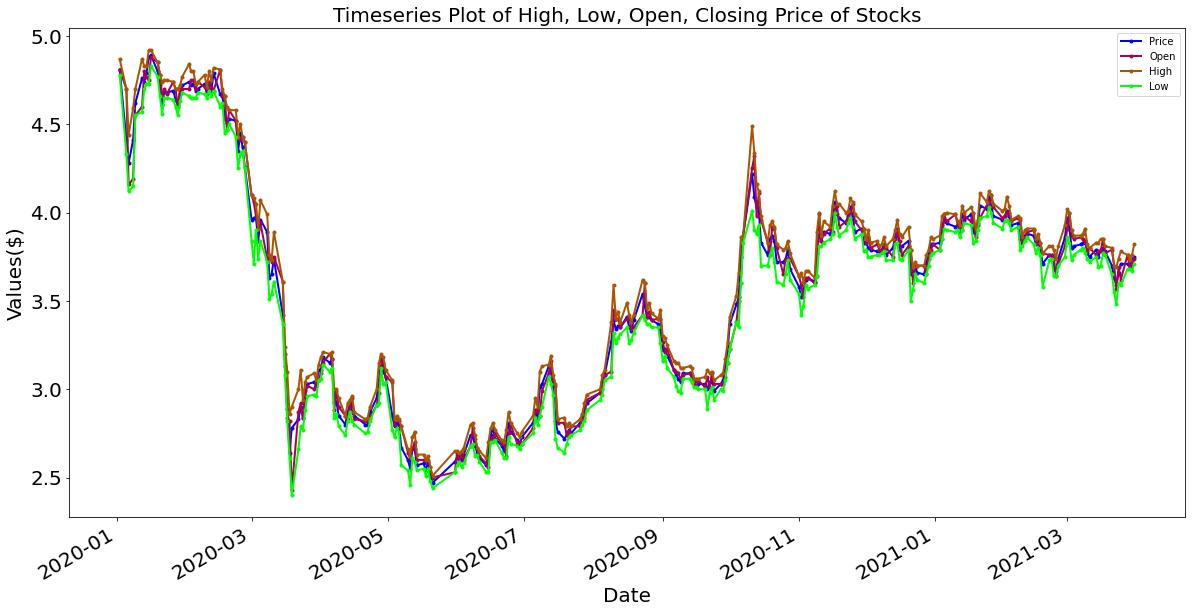

In [7]:
timeseries_plot(df)

In [8]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

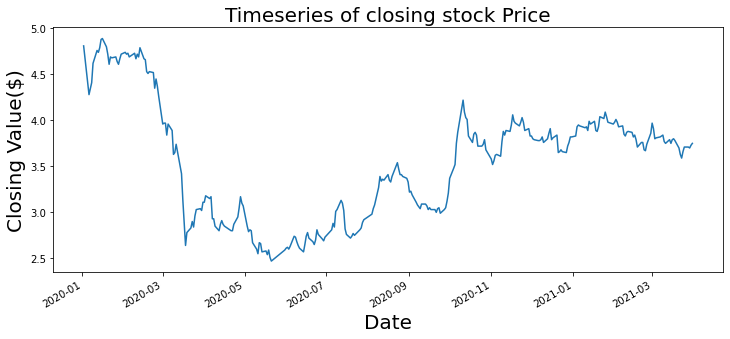

In [9]:
timeseries_plot_closing_value(df)

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


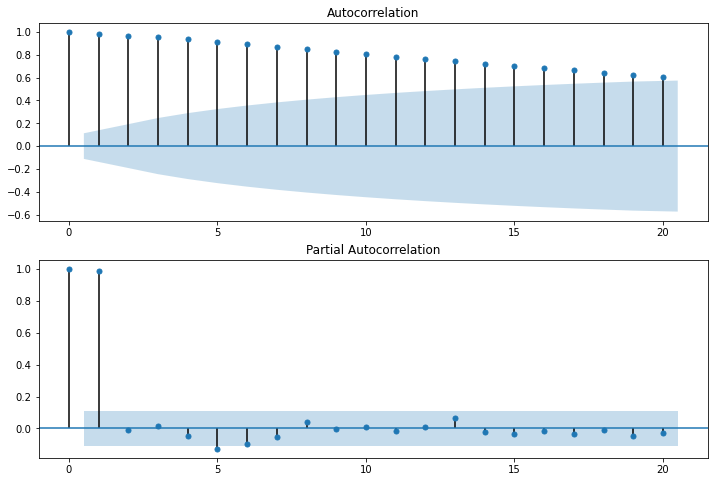

In [11]:
acf_pacf_plot(df)

# Dickey Fuller Test

In [12]:
#If the dataset is not stationary--

def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [13]:
df = stationary(df)

The p-value is 0.43075156928215697 reject the null hypthesis and data is not stationary
The p-value after first difference is 1.2158934574344105e-26, accept the null hypothesis and data is stationary


In [14]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
303,2020-01-05,4.41,4.70,4.70,4.33,-0.40
302,2020-01-06,4.28,4.16,4.44,4.12,-0.13
301,2020-01-08,4.41,4.19,4.59,4.15,0.13
300,2020-01-09,4.62,4.55,4.70,4.55,0.21
299,2020-01-12,4.76,4.60,4.87,4.57,0.14
...,...,...,...,...,...,...
4,2021-03-25,3.71,3.62,3.78,3.59,0.05
3,2021-03-28,3.71,3.76,3.76,3.68,0.00
2,2021-03-29,3.70,3.69,3.73,3.68,-0.01
1,2021-03-30,3.73,3.71,3.76,3.67,0.03


In [15]:
df_final = df.set_index('Date')

In [16]:
df_final.tail()

,Price,Open,High,Low,Difference
Date,,,,,
2021-03-25,3.71,3.62,3.78,3.59,0.05
2021-03-28,3.71,3.76,3.76,3.68,0.00
2021-03-29,3.70,3.69,3.73,3.68,-0.01
2021-03-30,3.73,3.71,3.76,3.67,0.03
2021-03-31,3.75,3.74,3.82,3.71,0.02


In [17]:
df_train = df_final.loc[:'2020']
df_test = df_final.loc['2021':]

In [18]:
#use a for loop for testing data! for 61 days

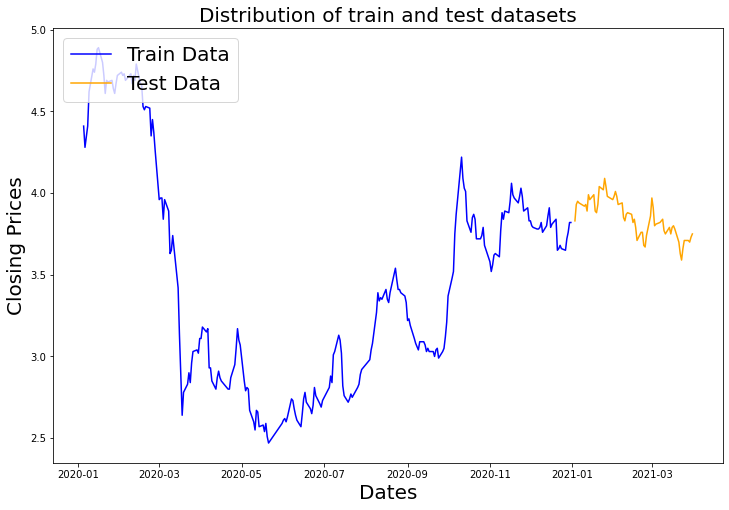

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df_train['Price'],color='blue', label='Train Data')
plt.plot(df_test['Price'],color='orange', label='Test Data')
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Closing Prices',fontsize=20)
plt.legend(loc='upper left',fontsize=20)
plt.title('Distribution of train and test datasets',fontsize=20)
plt.show()

In [20]:
df_train

,Price,Open,High,Low,Difference
Date,,,,,
2020-01-05,4.41,4.70,4.70,4.33,-0.40
2020-01-06,4.28,4.16,4.44,4.12,-0.13
2020-01-08,4.41,4.19,4.59,4.15,0.13
2020-01-09,4.62,4.55,4.70,4.55,0.21
2020-01-12,4.76,4.60,4.87,4.57,0.14
...,...,...,...,...,...
2020-12-27,3.65,3.70,3.70,3.60,-0.01
2020-12-28,3.72,3.65,3.76,3.65,0.07
2020-12-29,3.76,3.74,3.79,3.70,0.04


In [21]:
df_test

,Price,Open,High,Low,Difference
Date,,,,,
2021-01-03,3.83,3.79,3.87,3.79,0.01
2021-01-04,3.93,3.85,3.98,3.85,0.10
2021-01-05,3.95,3.99,3.99,3.91,0.02
2021-01-06,3.94,3.95,4.00,3.90,-0.01
2021-01-10,3.92,3.99,3.99,3.89,-0.02
...,...,...,...,...,...
2021-03-25,3.71,3.62,3.78,3.59,0.05
2021-03-28,3.71,3.76,3.76,3.68,0.00
2021-03-29,3.70,3.69,3.73,3.68,-0.01


## ARIMA Model

In [22]:
 arima_model = pm.auto_arima(df_train.Price, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [23]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 246.732
Date:                Thu, 23 Jun 2022   AIC                           -487.465
Time:                        12:58:21   BIC                           -477.010
Sample:                             0   HQIC                          -483.253
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0020      0.006     -0.351      0.725      -0.013       0.009
ar.L1          0.2294      0.045      5.122      0.000       0.142       0.317
sigma2         0.0076      0.001     14.769      0.0

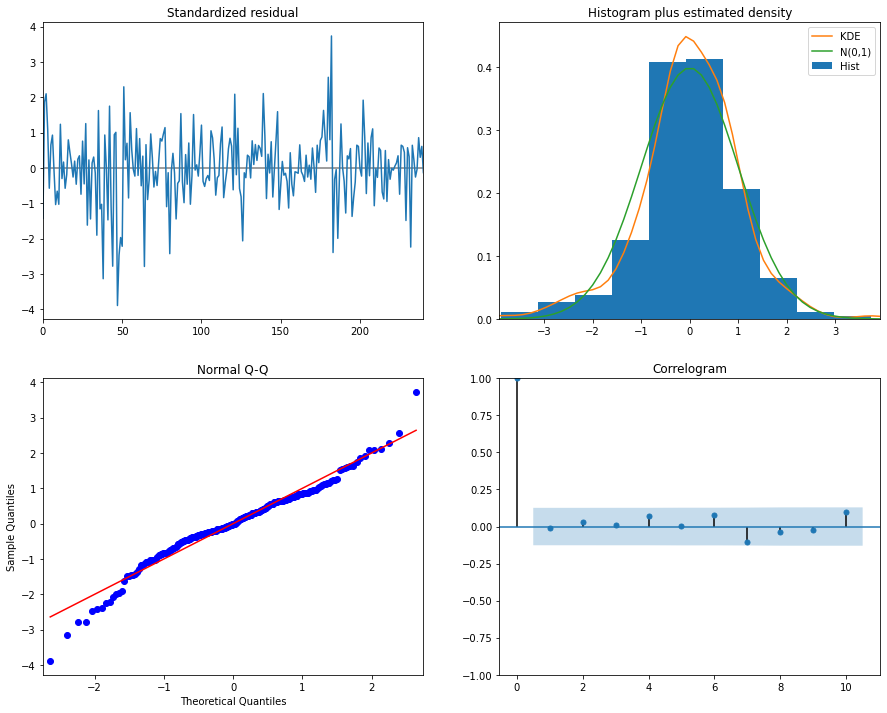

In [24]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [25]:
arima = statsmodels.tsa.arima.model.ARIMA(df_train.Price,order=(1,1,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [26]:
arima_fit = arima.fit()

In [27]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  242
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 246.668
Date:                Thu, 23 Jun 2022   AIC                           -489.336
Time:                        12:58:23   BIC                           -482.366
Sample:                             0   HQIC                          -486.528
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2289      0.045      5.118      0.000       0.141       0.317
sigma2         0.0076      0.001     15.103      0.000       0.007       0.009
Ljung-Box (Q):                       44.52   Jarque-

In [28]:
y_pred = arima_model.predict(len(df_test['Price']))

In [29]:
y_pred

array([3.8180002 , 3.81554158, 3.8129777 , 3.81038966, 3.80779607,
       3.80520122, 3.80260608, 3.80001086, 3.79741564, 3.79482041,
       3.79222517, 3.78962994, 3.78703471, 3.78443948, 3.78184425,
       3.77924902, 3.77665379, 3.77405855, 3.77146332, 3.76886809,
       3.76627286, 3.76367763, 3.7610824 , 3.75848716, 3.75589193,
       3.7532967 , 3.75070147, 3.74810624, 3.74551101, 3.74291577,
       3.74032054, 3.73772531, 3.73513008, 3.73253485, 3.72993962,
       3.72734438, 3.72474915, 3.72215392, 3.71955869, 3.71696346,
       3.71436823, 3.71177299, 3.70917776, 3.70658253, 3.7039873 ,
       3.70139207, 3.69879684, 3.6962016 , 3.69360637, 3.69101114,
       3.68841591, 3.68582068, 3.68322545, 3.68063022, 3.67803498,
       3.67543975, 3.67284452, 3.67024929, 3.66765406, 3.66505883,
       3.66246359, 3.65986836])

In [30]:
fc = len(df_test['Price'])
fc_series = pd.Series(y_pred,index=df_test['Price'].index)

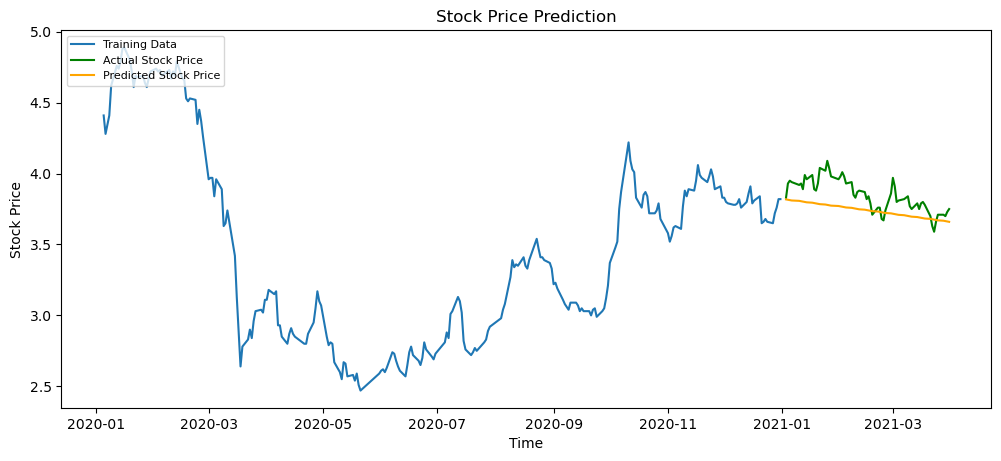

In [31]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df_train.Price,label='Training Data')
plt.plot(df_test.Price,color='green',label='Actual Stock Price')
plt.plot(fc_series,color='orange',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [32]:
fc_series

Date
2021-01-03    3.818000
2021-01-04    3.815542
2021-01-05    3.812978
2021-01-06    3.810390
2021-01-10    3.807796
                ...   
2021-03-25    3.670249
2021-03-28    3.667654
2021-03-29    3.665059
2021-03-30    3.662464
2021-03-31    3.659868
Length: 62, dtype: float64

In [33]:
mape = np.mean(np.abs(fc-df_test['Price'])/np.abs(df_test['Price']))
print(mape)

15.13015457233408


In [34]:
 mean_absolute_error(df_test.Price, y_pred)

0.11690152201553511

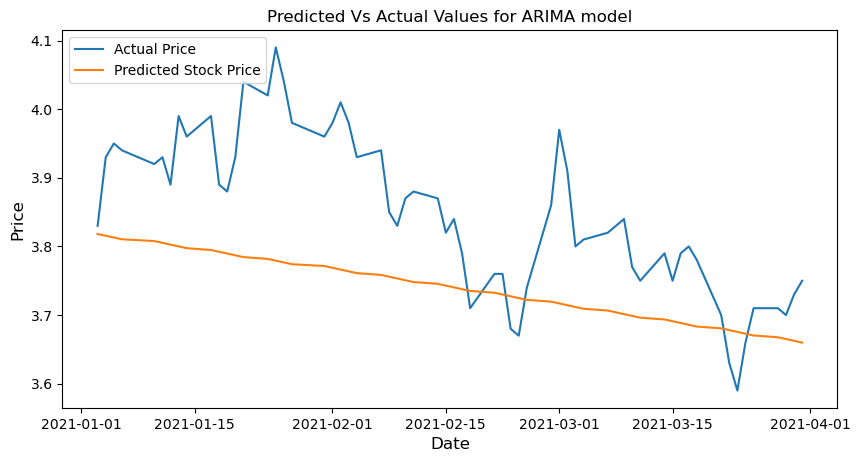

In [35]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df_test.Price,label='Actual Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.title('Predicted Vs Actual Values for ARIMA model')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

## Time Series Cross Validation

Observations: 152
Training Observations: 76
Testing Observations: 76


<Figure size 432x288 with 0 Axes>

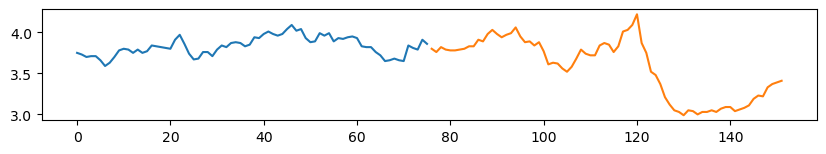

Observations: 228
Training Observations: 152
Testing Observations: 76


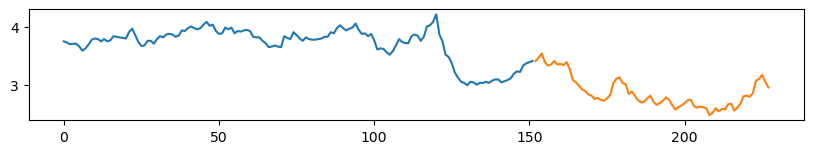

Observations: 304
Training Observations: 228
Testing Observations: 76


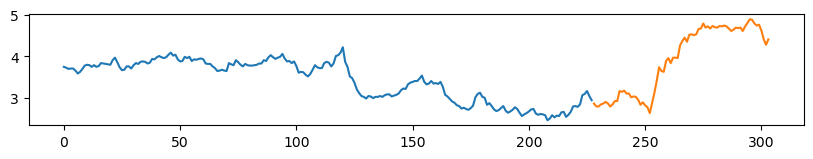

In [36]:

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df.Price
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.figure(figsize=(10,5),dpi=100)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
    pyplot.show()

In [37]:
from matplotlib import pyplot

X = df.Price
n_train = 249
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=249, test=1
train=250, test=1
train=251, test=1
train=252, test=1
train=253, test=1
train=254, test=1
train=255, test=1
train=256, test=1
train=257, test=1
train=258, test=1
train=259, test=1
train=260, test=1
train=261, test=1
train=262, test=1
train=263, test=1
train=264, test=1
train=265, test=1
train=266, test=1
train=267, test=1
train=268, test=1
train=269, test=1
train=270, test=1
train=271, test=1
train=272, test=1
train=273, test=1
train=274, test=1
train=275, test=1
train=276, test=1
train=277, test=1
train=278, test=1
train=279, test=1
train=280, test=1
train=281, test=1
train=282, test=1
train=283, test=1
train=284, test=1
train=285, test=1
train=286, test=1
train=287, test=1
train=288, test=1
train=289, test=1
train=290, test=1
train=291, test=1
train=292, test=1
train=293, test=1
train=294, test=1
train=295, test=1
train=296, test=1
train=297, test=1
train=298, test=1
train=299, test=1
train=300, test=1
train=301, test=1
train=302, test=1
train=303, test=1


In [38]:
x = df_final['Price']
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,0)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-03-31   3.75        3.734798


In [39]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,0)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-02-17   3.79        3.842635
2021-02-18   3.71        3.777216
2021-02-21   3.76        3.690324
2021-02-22   3.76        3.768901
2021-02-23   3.68        3.758056
2021-02-24   3.67        3.660499
2021-02-25   3.74        3.665652
2021-02-28   3.86        3.753144
2021-03-01   3.97        3.884754
2021-03-02   3.91        3.993435
2021-03-03   3.80        3.895291
2021-03-04   3.81        3.773675
2021-03-07   3.82        3.810468
2021-03-08   3.83        3.820502
2021-03-09   3.84        3.830536
2021-03-10   3.77        3.840570
2021-03-11   3.75        3.752699
2021-03-14   3.79        3.743702
2021-03-15   3.75        3.797066
2021-03-16   3.79        3.739344
2021-03-17   3.80        3.796999
2021-03-18   3.78        3.800467
2021-03-21   3.70        3.773856
2021-03-22   3.63        3.680474
2021-03-23   3.59        3.612361
2021-03-24   3.66        3.578875
2021-03-25   3.71        3.673385
2021-03-28   3

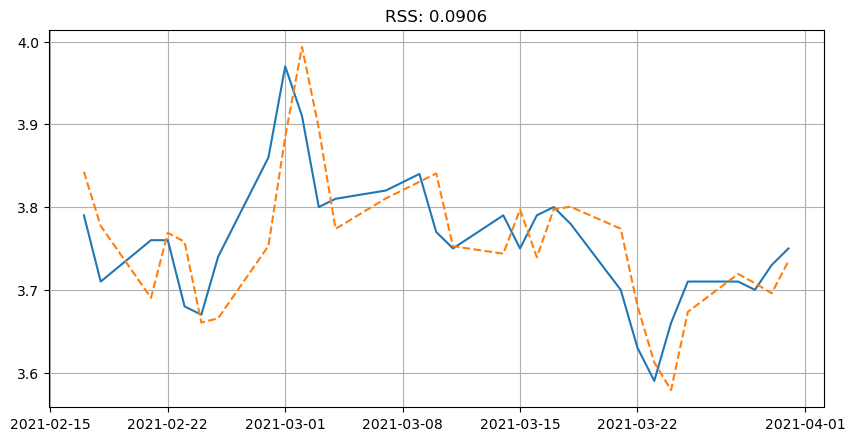

Test RMSE for ARIMA with Walk-Forward Validation:  0.054049238868998394


In [40]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(test_['Price'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Price'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [41]:
mape = np.mean(np.abs(prediction-test.values)/np.abs(test.values))
print(mape)

0.011706430797925499


# LSTM Model

In [42]:
df = timeseries_preprocessing(df_eg)

<ipython-input-4-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-4-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-4-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [43]:
df

,Date,Price,Open,High,Low
303,2020-01-05,4.41,4.70,4.70,4.33
302,2020-01-06,4.28,4.16,4.44,4.12
301,2020-01-08,4.41,4.19,4.59,4.15
300,2020-01-09,4.62,4.55,4.70,4.55
299,2020-01-12,4.76,4.60,4.87,4.57
...,...,...,...,...,...
4,2021-03-25,3.71,3.62,3.78,3.59
3,2021-03-28,3.71,3.76,3.76,3.68
2,2021-03-29,3.70,3.69,3.73,3.68
1,2021-03-30,3.73,3.71,3.76,3.67


In [44]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [45]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [46]:
train_test_boundary

62

In [47]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [48]:
df = df.set_index('Date')

In [49]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-05,4.41,4.70,4.70,4.33,2020
2020-01-06,4.28,4.16,4.44,4.12,2020
2020-01-08,4.41,4.19,4.59,4.15,2020
2020-01-09,4.62,4.55,4.70,4.55,2020
2020-01-12,4.76,4.60,4.87,4.57,2020
...,...,...,...,...,...
2021-03-25,3.71,3.62,3.78,3.59,2021
2021-03-28,3.71,3.76,3.76,3.68,2021
2021-03-29,3.70,3.69,3.73,3.68,2021


In [50]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [51]:
#global variables
n_steps = 3
n_features = 1


In [52]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [53]:
#defining the training dataframe
train_df = df[:-train_test_boundary]
    
#defining the testing dataframe
test_df = df[-train_test_boundary:]

In [54]:
train_df.shape

(242, 4)

In [55]:
test_df.shape

(62, 4)

In [56]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [57]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [58]:
X_train.shape,y_train.shape

((239, 3, 1), (239,))

In [59]:
X_test.shape,y_test.shape

((59, 3, 1), (59,))

In [60]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [61]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [62]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-09,4.62,4.302814
2020-01-12,4.76,4.375230
2020-01-13,4.74,4.547515
2020-01-14,4.79,4.666428
2020-01-15,4.88,4.734568
...,...,...
2021-03-25,3.71,3.598106
2021-03-28,3.71,3.626661
2021-03-29,3.70,3.663827


In [63]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 0.12220101926750576


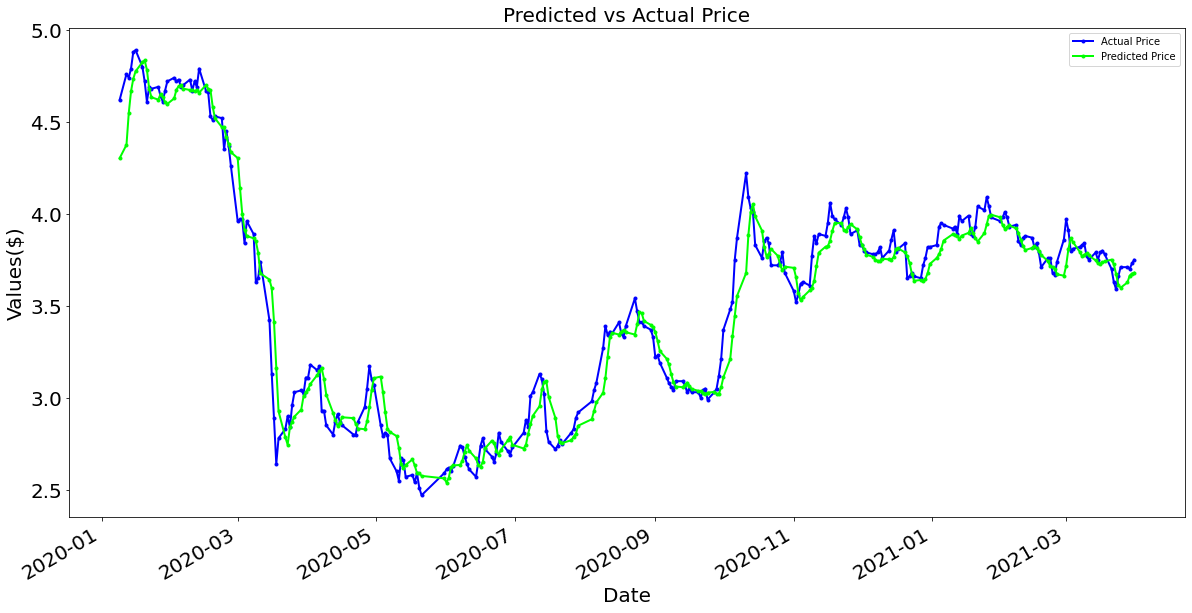

In [64]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

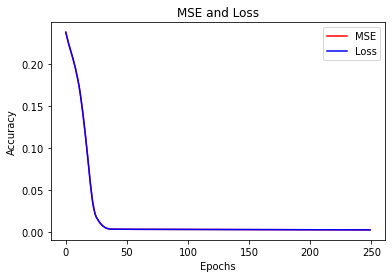

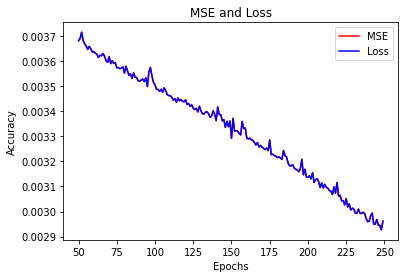

<Figure size 432x288 with 0 Axes>

In [65]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])


plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [66]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [67]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $79125.8300000001 with sma of 50 using a bollinger parameter 10


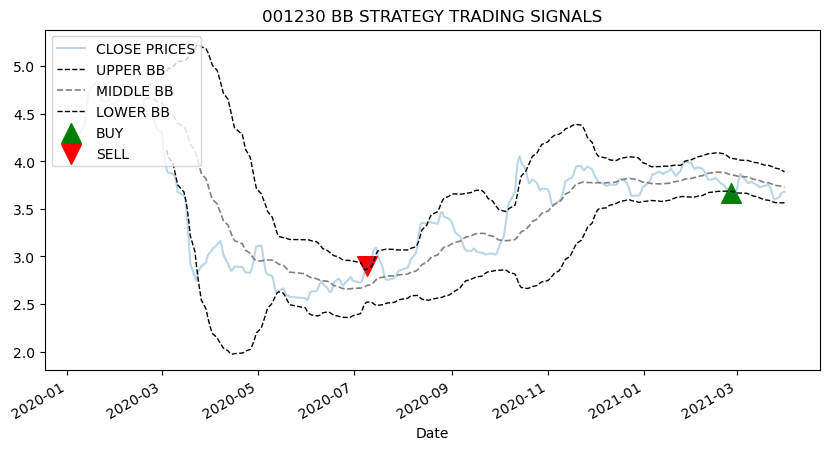

In [68]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)
plt.figure(figsize=(10,5),dpi=100)
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()